# Example runs of Neural Networks

This notebook contains example runs of the class NeuralNetwork in ```neural_network.py```. It is a class implementing fully connected neural networks, with various extensions. It is not done layerwise, and the differentiation is done as implemented analytical solutions. It is implemented "from scratch", only using numpy. It is fully vectorized, over both the noes in the layers, and the inputs in the minibatch.

In [54]:
import numpy as np
from neural_network import NeuralNetwork
from common import find_accuracy
from activation_functions import Sigmoid, Tanh, ReLU
from data.data_loaders import load_mnist, load_fashion_mnist, load_cifar10
from data.data_visualizer import (plot_mnist_random, plot_mnist_worst, plot_cifar_random, plot_cifar_worst)

from sklearn.datasets import load_diabetes
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split

## Classification, Multilabel Classifcation and Regression.

We will first look at the very basic features of the network, which is classification (both multiclass and multilabel) and regression.
We will note care about performance yet, just display how to run the class.

### Classification

Let us start with the simple and popular example of classifying the MNIST dataset.
We will not fuss over performance here, and just train with vanilla stochastic gradient descent (SGD) and no fancy weight-initialization, optimizer or dropout yet.

In [2]:
# Load the dataset
train_data, val_data, test_data = load_mnist(path="data/", transform=True, normalize=False)
x_train, y_train = train_data
x_val, y_val = val_data
x_test, y_test = test_data

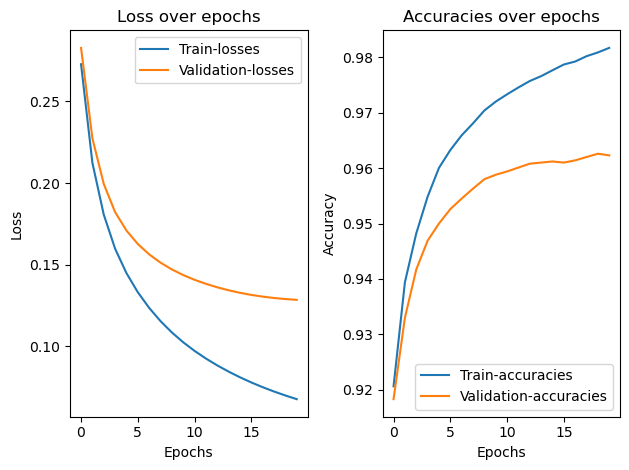

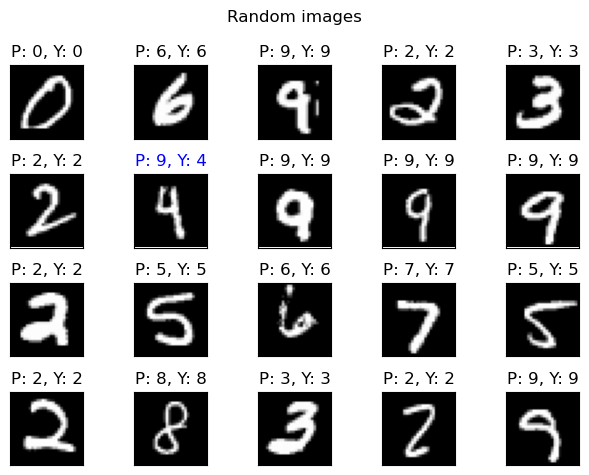

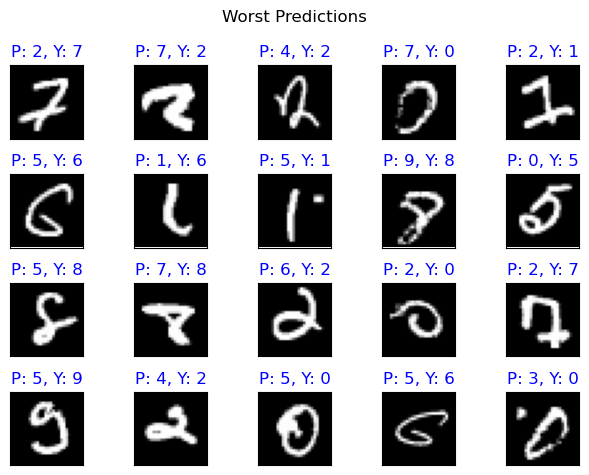

In [3]:
np.random.seed(57)
nn = NeuralNetwork([784, 30, 10], model_type="multiclass")  # Initialize class
nn.train(x_train, y_train, eta=1, epochs=20, eval_set=(x_val, y_val), minibatch_size=128)
preds = nn.predict(x_test)  # Predict
logits = nn._forward(x_test)
nn.plot_stats()  # Plot training stats
plot_mnist_random(x_test, preds=preds, labels=y_test, n_random=20, title="Random images")  # Plot random images
plot_mnist_worst(x_test, logits=logits, labels=y_test, n_images=20, title="Worst Predictions")  # Plot worst classified

### Multilabel Classification

Let us make a toy dataset to check the implementation of multilabel classification.

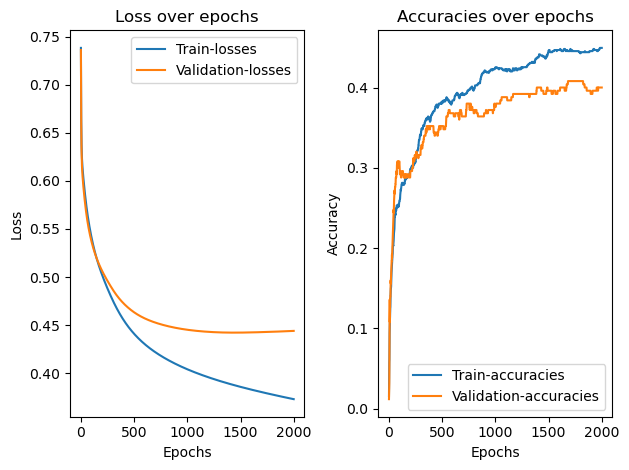

In [4]:
np.random.seed(57)
x_data, y_data = make_multilabel_classification(1000, 20)  # Make 1000 observations with 20 features and 5 outputs
x_train_l, x_val_l, y_train_l, y_val_l = train_test_split(x_data, y_data, test_size=0.25)
nn = NeuralNetwork([20, 15, 5], model_type="multilabel")
nn.train(x_train_l, y_train_l, eta=0.02, epochs=2000, eval_set=(x_val_l, y_val_l), verbose=False, minibatch_size=128)
nn.plot_stats()

### Regression

Let's load the diabetes toy dataset for regression:

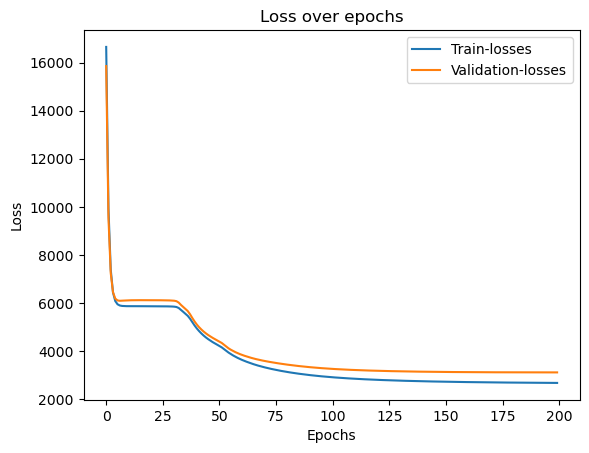

In [5]:
np.random.seed(57)
diabetes = load_diabetes()
x_train_d, x_val_d, y_train_d, y_val_d = train_test_split(diabetes["data"][:, 0:9], diabetes["target"], test_size=0.25)
nn = NeuralNetwork([9, 5, 1], model_type="regression")
nn.train(x_train_d, y_train_d, eval_set=(x_val_d, y_val_d), eta=0.005, minibatch_size=20, epochs=200)
nn.plot_stats()  # SGD manage to escape local optimum, not possible with minibatch_size = 331 (input size)

## Weight initialization and Activation Functions

We will now look at the different way of initializing weights, and we will use some different activation functions.
In general, Xavier-Glorot initialization is meant for sigmoid or tanh layers, while Kaiming-he is meant for ReLU. The "plain" initialization is uniformly initialized with 1 / sqrt(n), where n is the amount of nodes coming in from the previous layer. Note that in order to actually benchmark results, one should tune the parameters better and average over many runs. This is just an example run, not a benchmark.

Let's try some different weight initializations and activation functions:

In [17]:
np.random.seed(57)
weight_initializations = ["plain", "plain", "standard_normal", "glorot_uniform", "glorot_normal",
                          "kaiming_he_uniform", "kaiming_he_normal"]

activation_functions = [[Sigmoid(), Sigmoid()], [Tanh(), Tanh()], [Sigmoid(), Sigmoid()],
                        [Sigmoid(), Sigmoid()], [Sigmoid(), Sigmoid()], [ReLU(), ReLU()], [ReLU(), ReLU()]]

learning_rates = [2, 0.2, 2, 2, 2, 0.2, 0.2]
for i in range(len(weight_initializations)):
    weight_in = weight_initializations[i]
    activ_funcs = activation_functions[i]
    eta = learning_rates[i]
    np.random.seed(57)
    nn = NeuralNetwork([784, 16, 16, 10], model_type="multiclass", weight_initialization=weight_in,
                       activation_functions=activ_funcs)
    nn.train(x_train, y_train, eta=eta, epochs=10, verbose=False, minibatch_size=128)
    preds = nn.predict(x_test)
    accuracy = find_accuracy(preds, y_test)
    print(f"Accuracy for {weight_in}: {accuracy}. \n")

Accuracy for plain: 0.9428. 

Accuracy for plain: 0.9435. 

Accuracy for standard_normal: 0.9211. 

Accuracy for glorot_uniform: 0.9414. 

Accuracy for glorot_normal: 0.9447. 

Accuracy for kaiming_he_uniform: 0.9358. 

Accuracy for kaiming_he_normal: 0.9447. 



## Regularization, Dropout and L2 penalty.

There are two directly implemented methods for regularization, dropout and L2 penalty (weight reduction).
We will look at the Fashion MNIST dataset.

In [19]:
# Load the dataset
train_data, val_data, test_data = load_fashion_mnist(path="data/", transform=True, normalize=False)
x_train, y_train = train_data
x_val, y_val = val_data
x_test, y_test = test_data

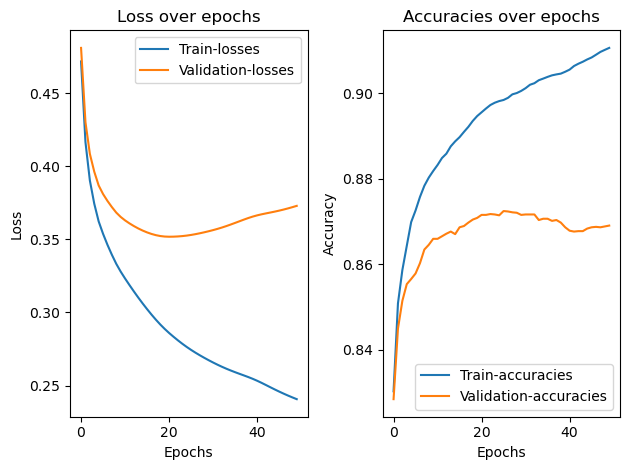

In [35]:
np.random.seed(57)
nn = NeuralNetwork([784, 30, 10], model_type="multiclass")  # Initialize class
nn.train(x_train, y_train, eta=1, epochs=50, eval_set=(x_val, y_val), minibatch_size=128)
nn.plot_stats()  # Plot training stats

We see that we begin to severerly overfit our network.

Let us first try to add a L2 penalty, with the same architecture and hyperparameters. The hyperparameter "lam" for "lambda" is the weight for the L2 penalty.



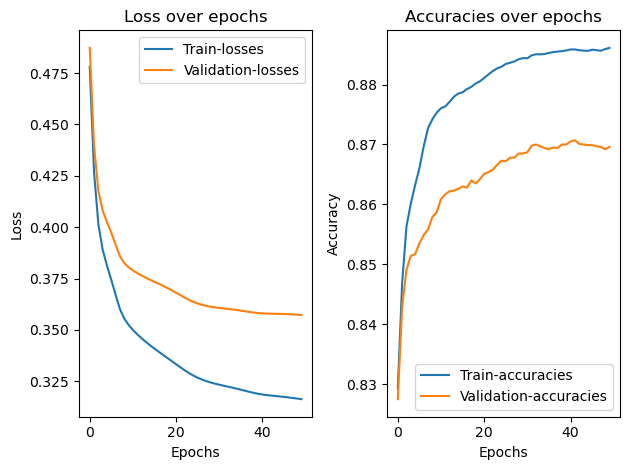

In [44]:
np.random.seed(57)
nn = NeuralNetwork([784, 30, 10], model_type="multiclass")  # Initialize class
nn.train(x_train, y_train, eta=1, epochs=50, eval_set=(x_val, y_val), minibatch_size=128, lam=0.03)
nn.plot_stats()  # Plot training stats

We see that we have prevented the overfitting, but the training is slower.

Lets use the same exact architecture and hyperparameters, but now with dropout. Note that the first number to "dropouts" is the layer between the inputs and the first hidden layer, which is often set to 1.

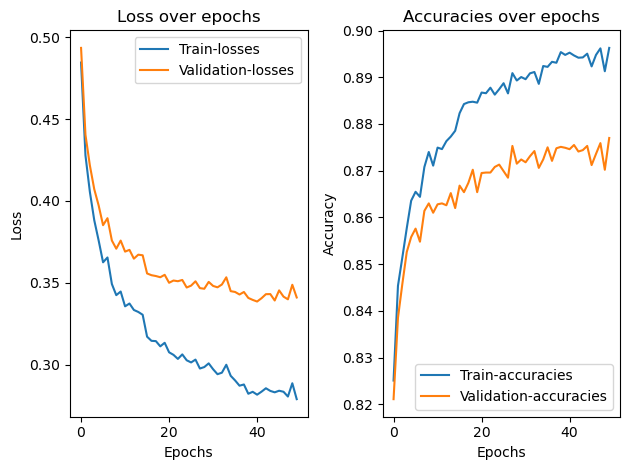

In [45]:
np.random.seed(57)
dropouts = [0.9, 0.75]
nn = NeuralNetwork([784, 30, 10], model_type="multiclass", dropouts=dropouts)  # Initialize class
nn.train(x_train, y_train, eta=1, epochs=50, eval_set=(x_val, y_val), minibatch_size=128)
nn.plot_stats()  # Plot training stats

We do see that the training rate should be lowered for dropout (because of the wiggely and non-monotone train-loss function), but in order to overfit with lower learning rates we would have to train for much longer. Dropout is most usefull for deeper networks, anyway.

Finally, let us visualize some results.

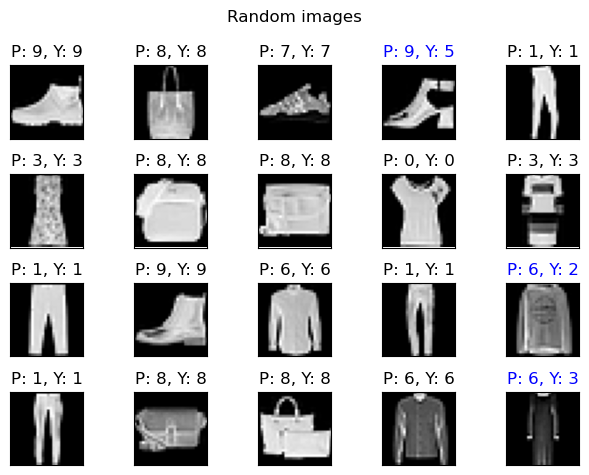

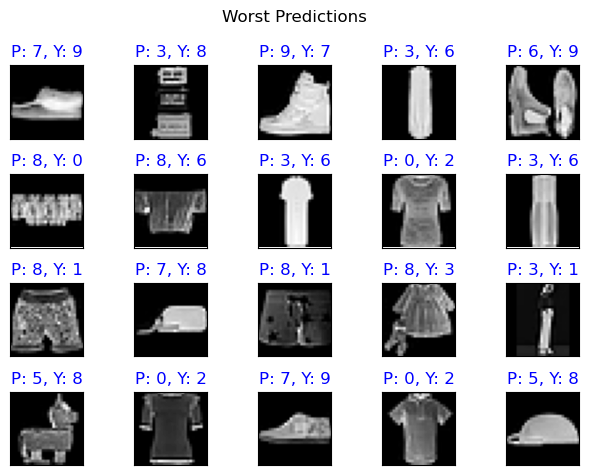

In [46]:
plot_mnist_random(x_test, preds=preds, labels=y_test, n_random=20, title="Random images")  # Plot random images
plot_mnist_worst(x_test, logits=logits, labels=y_test, n_images=20, title="Worst Predictions")  # Plot worst classified

## Optimizer

Now let us look at the different optimizers. The implemented ones are SGD, Classical Momentum, RMSprop and ADAM. We will return to the MNIST digit dataset.

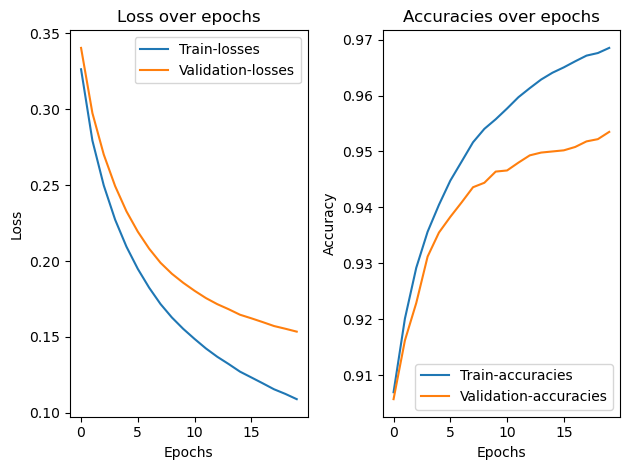

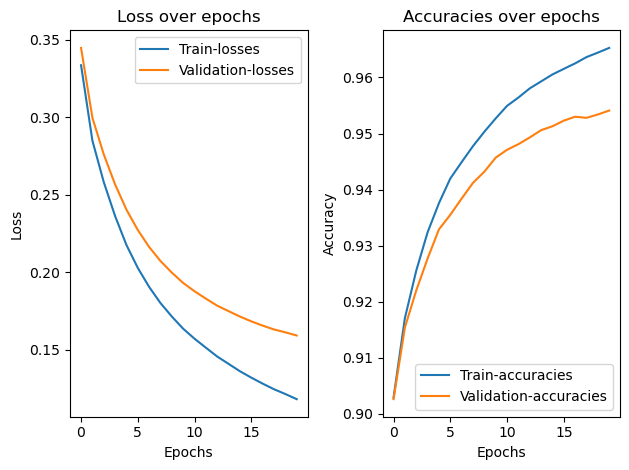

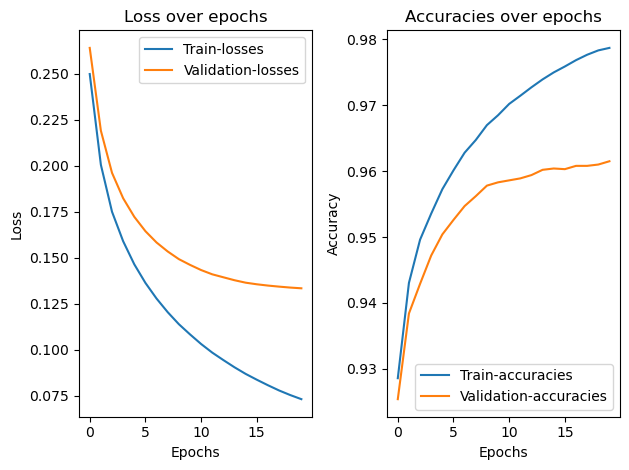

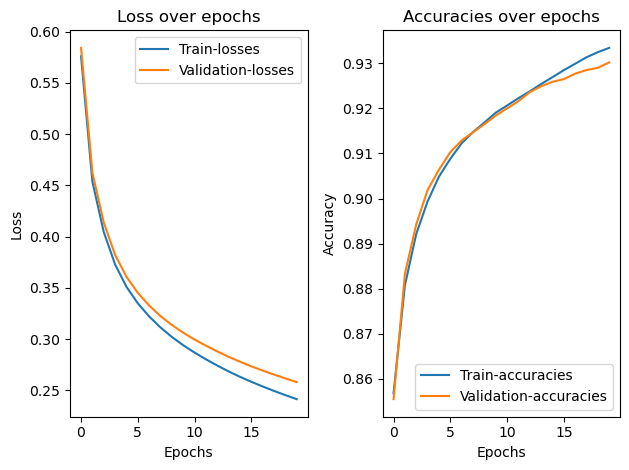

In [51]:
np.random.seed(57)
train_data, val_data, test_data = load_mnist(path="data/", transform=True, normalize=False)
x_train, y_train = train_data
x_val, y_val = val_data
x_test, y_test = test_data
optimizers = ["SGD", "Momentum", "RMS-prop", "ADAM"]
learning_rates = [0.1, 0.1, 0.1, 0.5]

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    eta = learning_rates[i]
    dropouts = [1, 1]
    nn = NeuralNetwork([784, 30, 10], model_type="multiclass", dropouts=dropouts,
                       weight_initialization="kaiming_he_normal", activation_functions=[ReLU()])
    nn.train(x_train, y_train, eta=eta, epochs=20, eval_set=(x_val, y_val), minibatch_size=128, optimizer=optimizer)
    preds = nn.predict(x_test)  # Predict
    nn.plot_stats()  # Plot training stats


## CIFAR dataset

We can also try to predict on the CIFAR dataset.

In [52]:
train_data, val_data, test_data = load_cifar10(path="data/", transform=True, normalize=False)
x_train, y_train = train_data
x_val, y_val = val_data
x_test, y_test = test_data

Epoch number 0
Train-loss: 2.04157, Validation-loss: 2.04329
Train-accuracy: 0.28602, Validation-accuracy: 0.28550
Epoch number 1
Train-loss: 1.97601, Validation-loss: 1.97777
Train-accuracy: 0.31410, Validation-accuracy: 0.31080
Epoch number 2
Train-loss: 1.94314, Validation-loss: 1.94515
Train-accuracy: 0.32490, Validation-accuracy: 0.32180
Epoch number 3
Train-loss: 1.91892, Validation-loss: 1.92083
Train-accuracy: 0.33372, Validation-accuracy: 0.33090
Epoch number 4
Train-loss: 1.89826, Validation-loss: 1.90022
Train-accuracy: 0.34373, Validation-accuracy: 0.34170
Epoch number 5
Train-loss: 1.87616, Validation-loss: 1.87847
Train-accuracy: 0.35635, Validation-accuracy: 0.35130
Epoch number 6
Train-loss: 1.85961, Validation-loss: 1.86240
Train-accuracy: 0.36185, Validation-accuracy: 0.35670
Epoch number 7
Train-loss: 1.84610, Validation-loss: 1.84924
Train-accuracy: 0.36667, Validation-accuracy: 0.36170
Epoch number 8
Train-loss: 1.83275, Validation-loss: 1.83629
Train-accuracy: 0.3

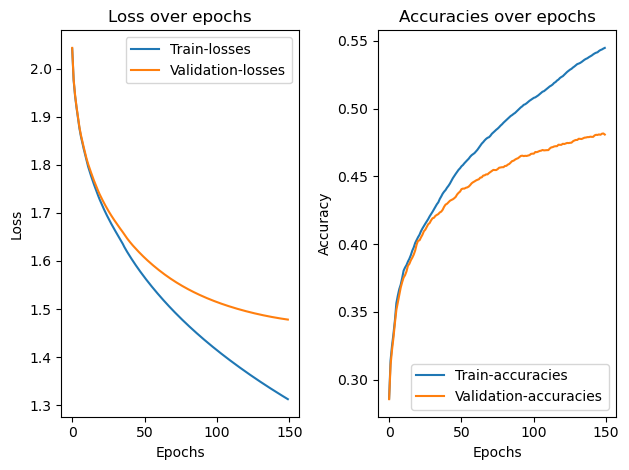

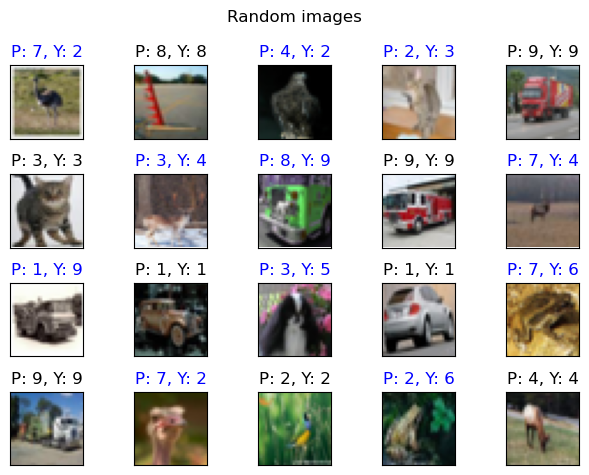

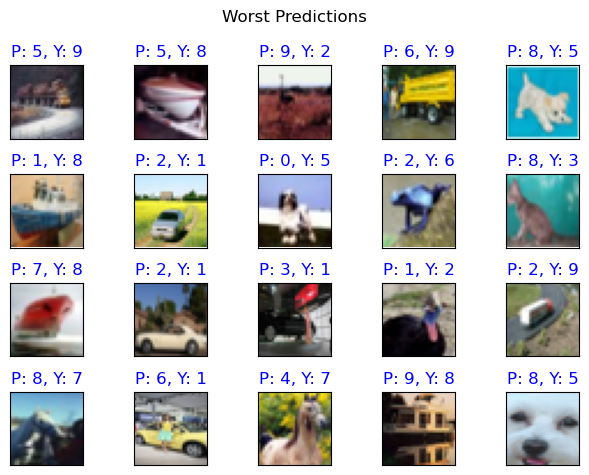

In [60]:
np.random.seed(57)
nn = NeuralNetwork([3072, 50, 10], model_type="multiclass")  # Initialize class
nn.train(x_train, y_train, eta=0.5, epochs=150, eval_set=(x_val, y_val), minibatch_size=128, optimizer="ADAM", verbose=True)
preds = nn.predict(x_test)  # Predict
logits = nn._forward(x_test)
nn.plot_stats()  # Plot training stats
plot_cifar_random(x_test, preds=preds, labels=y_test, n_random=20, title="Random images")  # Plot random images
plot_cifar_worst(x_test, logits=logits, labels=y_test, n_images=20, title="Worst Predictions")  # Plot worst classified